In [12]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Function to load and prepare data
def prepare_data(df):
    # Select only the tag columns (exclude 'date')
    tag_columns = [col for col in df.columns if col != 'date']
    X = df[tag_columns]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, tag_columns

In [20]:
# Function to perform parallel analysis
def parallel_analysis(X, n_iterations=1000, percentile=95):
    """
    Perform parallel analysis to determine number of components to retain
    
    Parameters:
    X : array-like of shape (n_samples, n_features)
        The input data
    n_iterations : int, default=1000
        Number of iterations for generating random data
    percentile : int, default=95
        Percentile for random eigenvalues
        
    Returns:
    tuple : (actual eigenvalues, 95th percentile of random eigenvalues)
    """
    n_samples, n_features = X.shape
    
    # Calculate eigenvalues for actual data
    pca = PCA()
    pca.fit(X)
    actual_eigenvals = pca.explained_variance_
    
    # Generate random eigenvalues
    random_eigenvals = np.zeros((n_iterations, n_features))
    for i in range(n_iterations):
        # Generate random normal data of same size
        random_data = np.random.normal(size=(n_samples, n_features))
        # Standardize the random data
        random_data = StandardScaler().fit_transform(random_data)
        # Get eigenvalues through PCA
        random_eigenvals[i] = PCA().fit(random_data).explained_variance_
    
    # Calculate percentile of random eigenvalues
    random_eigenvals_percentile = np.percentile(random_eigenvals, percentile, axis=0)
    
    return actual_eigenvals, random_eigenvals_percentile

In [14]:
# Function to perform PCA and get results
def perform_pca(X):
    pca = PCA()
    pca_result = pca.fit_transform(X)
    
    # Calculate explained variance ratio and cumulative sum
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    # Create eigenvalue table
    eigenvalue_table = pd.DataFrame({
        'Principal Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_))],
        'Initial Eigenvalue': pca.explained_variance_,
        'Variance (%)': explained_variance_ratio * 100,
        'Cumulative Variance (%)': cumulative_variance_ratio * 100
    })
    
    return eigenvalue_table, pca

In [15]:
# Function to create scree plot
def plot_scree(eigenvalue_table, title):
    plt.figure(figsize=(12, 6))
    
    # Plot initial eigenvalues
    plt.plot(range(1, len(eigenvalue_table) + 1), 
             eigenvalue_table['Initial Eigenvalue'],
             'bo-', linewidth=2)
    
    plt.xlabel('Principal Component')
    plt.ylabel('Initial Eigenvalue')
    plt.title(f'Scree Plot - {title}')
    plt.grid(True)
    plt.xticks(range(1, len(eigenvalue_table) + 1))
    
    # Add dashed line at eigenvalue = 1 (Kaiser criterion)
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Eigenvalue = 1 (Kaiser criterion)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [16]:
# Define file paths
msv_path = os.path.join("..", "gt_preprocessed_data", "gt_msv_stitched", "3_gt_msv_stitched_compute.csv")
rsv_path = os.path.join("..", "gt_preprocessed_data", "gt_rsv_stitched", "3_gt_rescaled_rsv.csv")

In [17]:
# Read the datasets
msv_df = pd.read_csv(msv_path)
rsv_df = pd.read_csv(rsv_path)

Analysis for MSV Dataset:

Eigenvalue Table for MSV Dataset:
Principal Component  Initial Eigenvalue  Variance (%)  Cumulative Variance (%)
                PC1            2.811879     18.694357                18.694357
                PC2            1.667703     11.087474                29.781831
                PC3            1.583184     10.525563                40.307394
                PC4            1.339516      8.905572                49.212965
                PC5            1.059828      7.046109                56.259074
                PC6            0.955783      6.354382                62.613456
                PC7            0.876809      5.829334                68.442790
                PC8            0.790746      5.257158                73.699948
                PC9            0.762277      5.067888                78.767836
               PC10            0.702397      4.669780                83.437617
               PC11            0.628290      4.177092                8

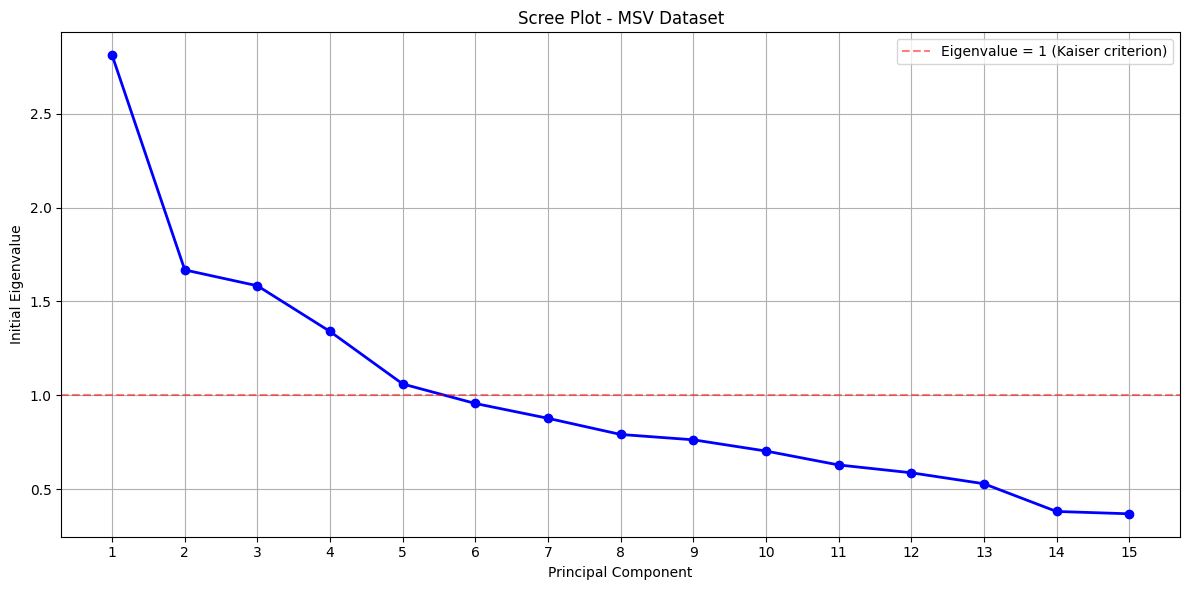

In [18]:
# Analyze MSV dataset
print("Analysis for MSV Dataset:")
X_msv, tags_msv = prepare_data(msv_df)
eigenvalue_table_msv, pca_msv = perform_pca(X_msv)
print("\nEigenvalue Table for MSV Dataset:")
print(eigenvalue_table_msv.to_string(index=False))
plot_scree(eigenvalue_table_msv, "MSV Dataset")

Analysis for RSV Dataset:

Eigenvalue Table for RSV Dataset:
Principal Component  Initial Eigenvalue  Variance (%)  Cumulative Variance (%)
                PC1            4.769144     31.707426                31.707426
                PC2            2.215622     14.730458                46.437883
                PC3            1.323722      8.800705                55.238588
                PC4            1.038974      6.907567                62.146156
                PC5            0.953044      6.336270                68.482425
                PC6            0.871124      5.791625                74.274051
                PC7            0.756703      5.030904                79.304955
                PC8            0.691418      4.596861                83.901816
                PC9            0.641689      4.266242                88.168058
               PC10            0.534435      3.553165                91.721223
               PC11            0.473880      3.150566                9

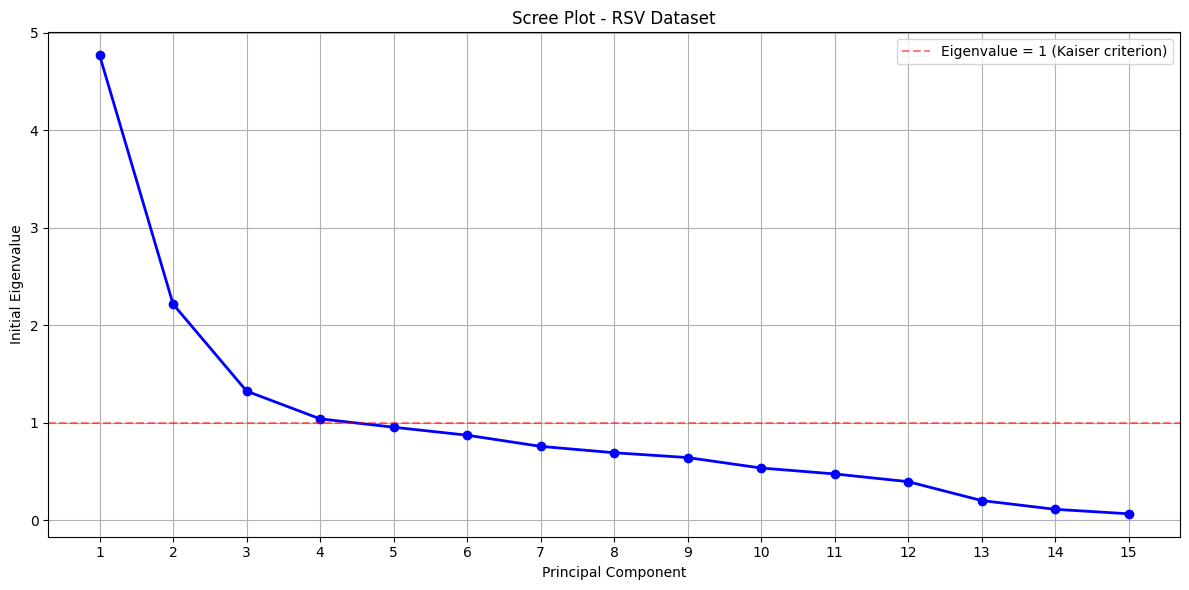

In [19]:
# Analyze RSV dataset
print("Analysis for RSV Dataset:")
X_rsv, tags_rsv = prepare_data(rsv_df)
eigenvalue_table_rsv, pca_rsv = perform_pca(X_rsv)
print("\nEigenvalue Table for RSV Dataset:")
print(eigenvalue_table_rsv.to_string(index=False))
plot_scree(eigenvalue_table_rsv, "RSV Dataset")

In [21]:
# Function to create scree plot with parallel analysis
def plot_scree(eigenvalue_table, title):
    plt.figure(figsize=(12, 6))
    
    # Plot initial eigenvalues
    plt.plot(range(1, len(eigenvalue_table) + 1), 
             eigenvalue_table['Initial Eigenvalue'],
             'bo-', linewidth=2, label='Actual Data')
    
    # Plot random eigenvalues
    plt.plot(range(1, len(eigenvalue_table) + 1), 
             eigenvalue_table['Random Eigenvalue (95th percentile)'],
             'ro--', linewidth=2, label='95th Percentile of Random Data')
    
    # Find intersection point
    intersection_point = sum(eigenvalue_table['Initial Eigenvalue'] > 
                           eigenvalue_table['Random Eigenvalue (95th percentile)'])
    
    plt.xlabel('Principal Component')
    plt.ylabel('Initial Eigenvalue')
    plt.title(f'Scree Plot with Parallel Analysis - {title}\n'
              f'Suggested number of components: {intersection_point}')
    plt.grid(True)
    plt.legend()
    plt.xticks(range(1, len(eigenvalue_table) + 1))
    
    # Add dashed line at eigenvalue = 1 (Kaiser criterion)
    plt.axhline(y=1, color='g', linestyle='--', alpha=0.5, label='Kaiser criterion (Eigenvalue = 1)')
    
    plt.tight_layout()
    plt.show()

In [22]:
# Set random seed for reproducibility
np.random.seed(42)

In [24]:
# Function to perform PCA and get results
def perform_pca(X):
    pca = PCA()
    pca_result = pca.fit_transform(X)
    
    # Calculate explained variance ratio and cumulative sum
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    # Get parallel analysis results
    actual_eigenvals, random_eigenvals = parallel_analysis(X)
    
    # Determine number of components to retain
    n_components = sum(actual_eigenvals > random_eigenvals)
    
    # Create eigenvalue table
    eigenvalue_table = pd.DataFrame({
        'Principal Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_))],
        'Initial Eigenvalue': pca.explained_variance_,
        'Random Eigenvalue (95th percentile)': random_eigenvals,
        'Variance (%)': explained_variance_ratio * 100,
        'Cumulative Variance (%)': cumulative_variance_ratio * 100
    })
    
    return eigenvalue_table, pca, n_components

Analysis for MSV Dataset:

Eigenvalue Table for MSV Dataset:
Principal Component  Initial Eigenvalue  Random Eigenvalue (95th percentile)  Variance (%)  Cumulative Variance (%)
                PC1            2.811879                             1.440917     18.694357                18.694357
                PC2            1.667703                             1.339851     11.087474                29.781831
                PC3            1.583184                             1.270350     10.525563                40.307394
                PC4            1.339516                             1.208443      8.905572                49.212965
                PC5            1.059828                             1.156657      7.046109                56.259074
                PC6            0.955783                             1.108913      6.354382                62.613456
                PC7            0.876809                             1.067180      5.829334                68.442790
           

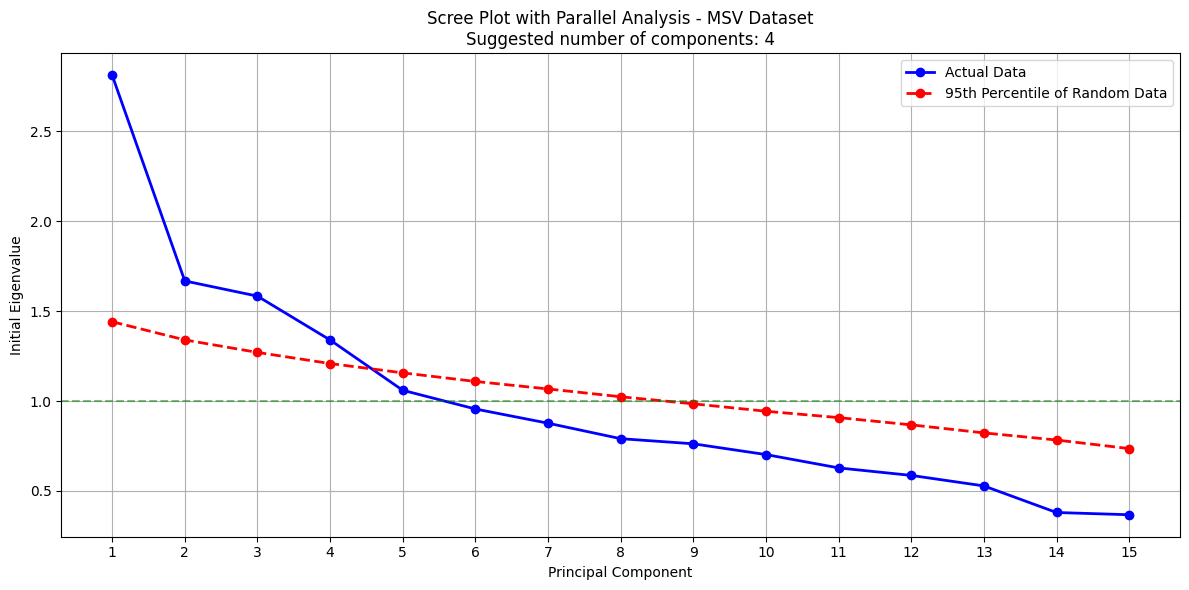

In [25]:
# Analyze MSV dataset
print("Analysis for MSV Dataset:")
X_msv, tags_msv = prepare_data(msv_df)
eigenvalue_table_msv, pca_msv, n_components_msv = perform_pca(X_msv)
print("\nEigenvalue Table for MSV Dataset:")
print(eigenvalue_table_msv.to_string(index=False))
print(f"\nSuggested number of components (MSV): {n_components_msv}")
plot_scree(eigenvalue_table_msv, "MSV Dataset")

Analysis for RSV Dataset:

Eigenvalue Table for RSV Dataset:
Principal Component  Initial Eigenvalue  Random Eigenvalue (95th percentile)  Variance (%)  Cumulative Variance (%)
                PC1            4.769144                             1.449106     31.707426                31.707426
                PC2            2.215622                             1.341495     14.730458                46.437883
                PC3            1.323722                             1.265148      8.800705                55.238588
                PC4            1.038974                             1.208331      6.907567                62.146156
                PC5            0.953044                             1.153676      6.336270                68.482425
                PC6            0.871124                             1.110479      5.791625                74.274051
                PC7            0.756703                             1.064270      5.030904                79.304955
           

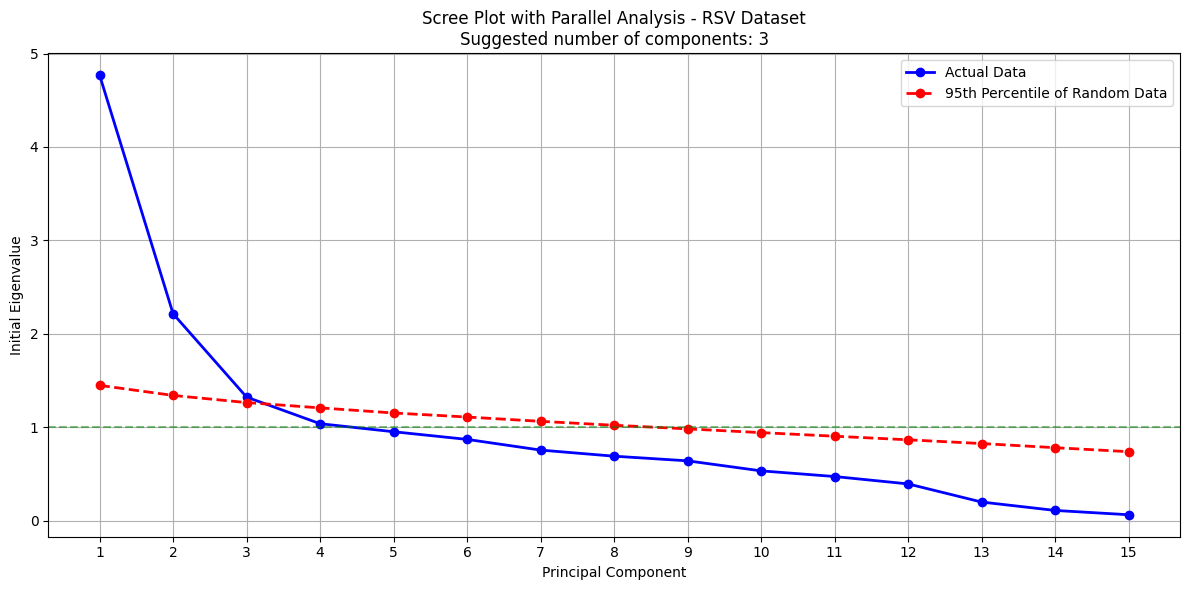

In [26]:
print("Analysis for RSV Dataset:")
X_rsv, tags_rsv = prepare_data(rsv_df)
eigenvalue_table_rsv, pca_rsv, n_components_rsv = perform_pca(X_rsv)
print("\nEigenvalue Table for RSV Dataset:")
print(eigenvalue_table_rsv.to_string(index=False))
print(f"\nSuggested number of components (RSV): {n_components_rsv}")
plot_scree(eigenvalue_table_rsv, "RSV Dataset")

In [30]:
# Function to perform PCA and get results
def perform_pca(X, n_components):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(X)
    
    # Calculate explained variance ratio and cumulative sum
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    # Create eigenvalue table
    eigenvalue_table = pd.DataFrame({
        'Principal Component': [f'PC{i+1}' for i in range(n_components)],
        'Initial Eigenvalue': pca.explained_variance_,
        'Variance (%)': explained_variance_ratio * 100,
        'Cumulative Variance (%)': cumulative_variance_ratio * 100
    })
    
    return eigenvalue_table, pca

In [31]:
# Function to create weight loading table
def create_loading_table(pca, feature_names, n_components):
    # Get component loadings
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    # Create DataFrame with loadings
    loading_table = pd.DataFrame(
        loadings[:, :n_components],
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=feature_names
    )
    
    # Round values to 4 decimal places
    loading_table = loading_table.round(4)
    
    return loading_table

In [32]:
# Function to create scree plot
def plot_scree(eigenvalue_table, title):
    plt.figure(figsize=(12, 6))
    
    # Plot initial eigenvalues
    plt.plot(range(1, len(eigenvalue_table) + 1), 
             eigenvalue_table['Initial Eigenvalue'],
             'bo-', linewidth=2)
    
    plt.xlabel('Principal Component')
    plt.ylabel('Initial Eigenvalue')
    plt.title(f'Scree Plot - {title}')
    plt.grid(True)
    plt.xticks(range(1, len(eigenvalue_table) + 1))
    
    # Add dashed line at eigenvalue = 1 (Kaiser criterion)
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Eigenvalue = 1 (Kaiser criterion)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Analysis for MSV Dataset (4 components):

Eigenvalue Table for MSV Dataset:
Principal Component  Initial Eigenvalue  Variance (%)  Cumulative Variance (%)
                PC1            2.811879     18.694357                18.694357
                PC2            1.667703     11.087474                29.781831
                PC3            1.583184     10.525563                40.307394
                PC4            1.339516      8.905572                49.212965


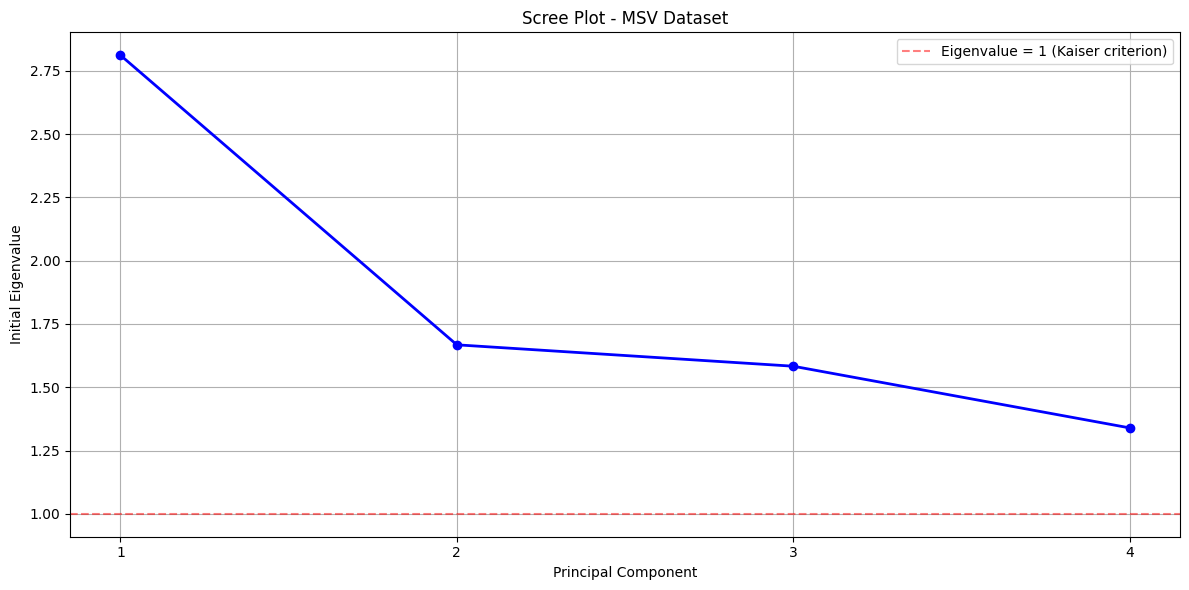


MSV Dataset Loading Table:
                      PC1     PC2     PC3     PC4
flu                0.5249 -0.2922  0.3714 -0.1006
cough              0.8115 -0.1079  0.0975 -0.0377
fever              0.7840 -0.1302 -0.0250  0.0471
headache           0.1585  0.1245 -0.3126  0.4582
lagnat             0.2027  0.0958 -0.3200  0.2987
rashes            -0.0534  0.3399 -0.5794  0.2874
sipon              0.6567  0.1737 -0.0741 -0.0638
ubo                0.5084  0.2070 -0.0402  0.2209
ecq               -0.1052  0.7270  0.3112 -0.0031
face shield        0.2089  0.2307  0.2262  0.5787
Frontliners       -0.4119  0.4990  0.2279 -0.1106
masks             -0.1748 -0.0666  0.2667  0.5175
Quarantine         0.3903  0.6758  0.2049 -0.2830
social distancing -0.2986 -0.2170  0.3832  0.4101
work from home     0.0891 -0.0399  0.6575  0.1671


In [33]:
# Analyze MSV dataset (4 components)
print("Analysis for MSV Dataset (4 components):")
X_msv, tags_msv = prepare_data(msv_df)
eigenvalue_table_msv, pca_msv = perform_pca(X_msv, 4)
print("\nEigenvalue Table for MSV Dataset:")
print(eigenvalue_table_msv.to_string(index=False))
plot_scree(eigenvalue_table_msv, "MSV Dataset")

# Create and display MSV loading table
loading_table_msv = create_loading_table(pca_msv, tags_msv, 4)
print("\nMSV Dataset Loading Table:")
print(loading_table_msv)

Analysis for RSV Dataset (3 components):

Eigenvalue Table for RSV Dataset:
Principal Component  Initial Eigenvalue  Variance (%)  Cumulative Variance (%)
                PC1            4.769144     31.707426                31.707426
                PC2            2.215622     14.730458                46.437883
                PC3            1.323722      8.800705                55.238588


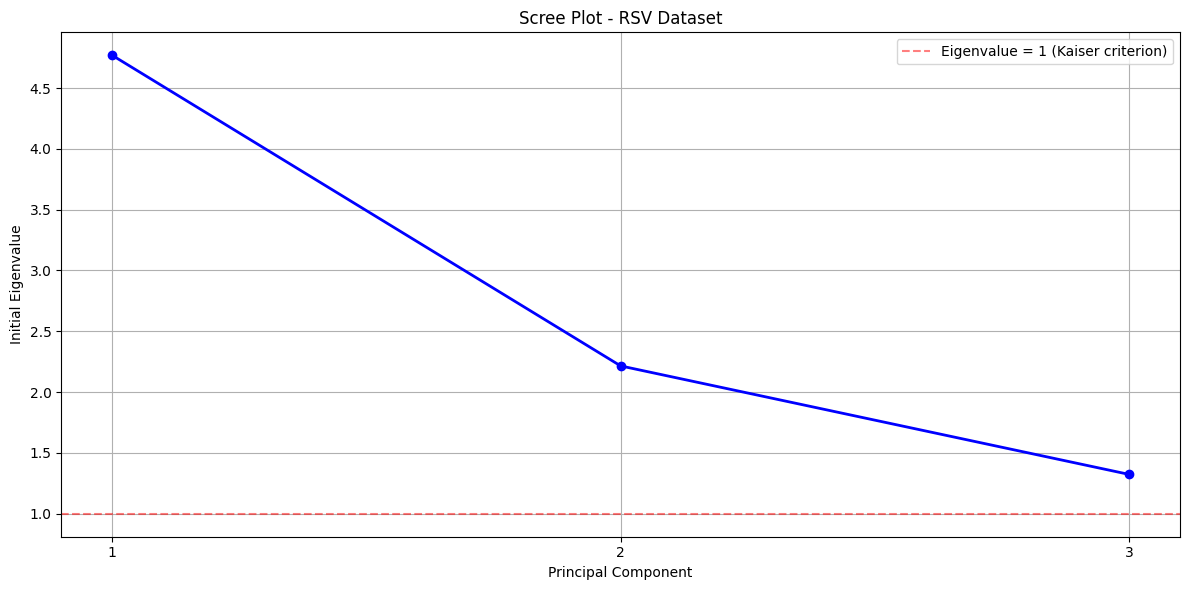


RSV Dataset Loading Table:
                      PC1     PC2     PC3
flu                0.8916 -0.1975 -0.0464
cough              0.7875 -0.4684 -0.0913
fever              0.8215 -0.3954  0.0732
headache           0.5755  0.0560  0.4742
lagnat             0.1403 -0.3058  0.2788
rashes             0.3429  0.4089  0.4496
sipon              0.0432 -0.6137  0.0684
ubo                0.2070 -0.5817 -0.0591
ecq                0.2803  0.7274  0.0824
face shield        0.0502 -0.0395  0.7114
Frontliners        0.4454  0.3287 -0.2786
masks              0.4535  0.2606  0.1631
Quarantine         0.8842  0.1640 -0.1938
social distancing  0.5768  0.2277 -0.3730
work from home     0.7526  0.1917 -0.0345


In [34]:
# Analyze RSV dataset (3 components)
print("Analysis for RSV Dataset (3 components):")
X_rsv, tags_rsv = prepare_data(rsv_df)
eigenvalue_table_rsv, pca_rsv = perform_pca(X_rsv, 3)
print("\nEigenvalue Table for RSV Dataset:")
print(eigenvalue_table_rsv.to_string(index=False))
plot_scree(eigenvalue_table_rsv, "RSV Dataset")

# Create and display RSV loading table
loading_table_rsv = create_loading_table(pca_rsv, tags_rsv, 3)
print("\nRSV Dataset Loading Table:")
print(loading_table_rsv)